# Customer Segmentation

This notebook runs the full segmentation pipeline: loading the data (uses the `market` sheet), feature engineering, clustering (KMeans), evaluation and visualizations. It also summarizes findings and actionable recommendations so you can export or present results directly from the notebook.

Assumptions:
- The repository contains `data_processing.py`, `features.py`, and `pipeline.py` which this notebook may import.
- Data source: `Supermarket Data.xlsx` downloaded from the Kaggle dataset into a cache; `data_processing.load_raw()` will prefer the `market` sheet.


In [96]:
# 1) Imports and environment
import sys
from pathlib import Path
repo_root = Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Ensure we can import packages from the managed virtual environment (.venv)
venv_site_packages = repo_root / '.venv' / 'Lib' / 'site-packages'
if venv_site_packages.exists() and str(venv_site_packages) not in sys.path:
    sys.path.insert(0, str(venv_site_packages))

print('Added repo root to sys.path:', repo_root)
if venv_site_packages.exists():
    print('Added .venv site-packages to sys.path:', venv_site_packages)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Helpers from this repo
from data_processing import load_raw
from features import build_transaction_features, build_store_aggregates

# Plot settings
%matplotlib inline
sns.set(style='whitegrid')

print('Notebook running with pandas', pd.__version__)


Added repo root to sys.path: C:\Users\jeff\Projects\customer_segmentation
Added .venv site-packages to sys.path: C:\Users\jeff\Projects\customer_segmentation\.venv\Lib\site-packages
Notebook running with pandas 2.3.3


In [97]:
# 2) Load data

# load_raw prefers the `market` sheet and handles column normalization
raw_df = load_raw()
print('Loaded dataframe shape:', raw_df.shape)
raw_df.head()


C:\Users\jeff\Projects\customer_segmentation\data_processing.py:69: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')


Loaded dataframe shape: (1464, 33)


,supermarket,no_of_items,variation,total,paid,change,type,food,snack,beverage,...,24hr,day_1,month,year,hour,item_no_cat,total_cat,paid_cat,change_cat,datetime
0,acacia,1,1,90.0,100,10.0,cash,yes,no,no,...,no,20,5,2017.0,19,A,1,1,1,2017-05-20 19:33:00
1,acacia,1,1,90.0,500,410.0,cash,yes,no,no,...,no,20,5,2017.0,19,A,1,1,1,2017-05-20 19:12:00
2,acacia,3,1,270.0,300,30.0,cash,yes,no,no,...,no,20,5,2017.0,19,B,1,1,1,2017-05-20 19:16:00
3,acacia,3,1,137.0,200,63.0,cash,yes,no,no,...,no,20,5,2017.0,19,B,1,1,1,2017-05-20 19:12:00
4,acacia,1,1,75.0,80,5.0,cash,yes,no,no,...,no,20,5,2017.0,18,A,1,1,1,2017-05-20 18:31:00


In [98]:
# 3) Quick inspection
print('Columns:', raw_df.columns.tolist())
print('\nMissing value counts (top 20):')
print(raw_df.isnull().sum().sort_values(ascending=False).head(20))

# Basic value counts for key categorical fields (if present)
for c in ['supermarket','payment_type','category']:
    if c in raw_df.columns:
        print(f"\nValue counts for {c} (top 10):")
        print(raw_df[c].value_counts().head(10))


Columns: ['supermarket', 'no_of_items', 'variation', 'total', 'paid', 'change', 'type', 'food', 'snack', 'beverage', 'consumables', 'high_end', 'asset', 'fixed_asset', 'date', 'mall', 'time', 'time_type', 'type_market', 'location', 'loc_category', 'day', 'day_type', '24hr', 'day_1', 'month', 'year', 'hour', 'item_no_cat', 'total_cat', 'paid_cat', 'change_cat', 'datetime']

Missing value counts (top 20):
datetime       3
year           2
supermarket    1
no_of_items    0
variation      0
change         0
type           0
total          0
paid           0
beverage       0
consumables    0
high_end       0
asset          0
fixed_asset    0
date           0
food           0
snack          0
time           0
mall           0
time_type      0
dtype: int64

Value counts for supermarket (top 10):
supermarket
karrymart     520
tumaini       268
nakumatt      180
cleanshelf    128
tuskys        126
ukwala         56
acacia         53
naivas         30
eastmatt       26
Tuskys         16
Name: co

In [99]:
# 4) Feature engineering

features = build_transaction_features(raw_df)
print('Features shape:', features.shape)
features.head()


Features shape: (1464, 13)


,no_of_items,variation,total,paid,change,hour,dayofweek,is_weekend,month,supermarket_freq,is_cash,is_card,is_mpesa
0,1,1,90.0,100,10.0,19.0,5.0,1,5.0,0.036202,1,0,0
1,1,1,90.0,500,410.0,19.0,5.0,1,5.0,0.036202,1,0,0
2,3,1,270.0,300,30.0,19.0,5.0,1,5.0,0.036202,1,0,0
3,3,1,137.0,200,63.0,19.0,5.0,1,5.0,0.036202,1,0,0
4,1,1,75.0,80,5.0,18.0,5.0,1,5.0,0.036202,1,0,0


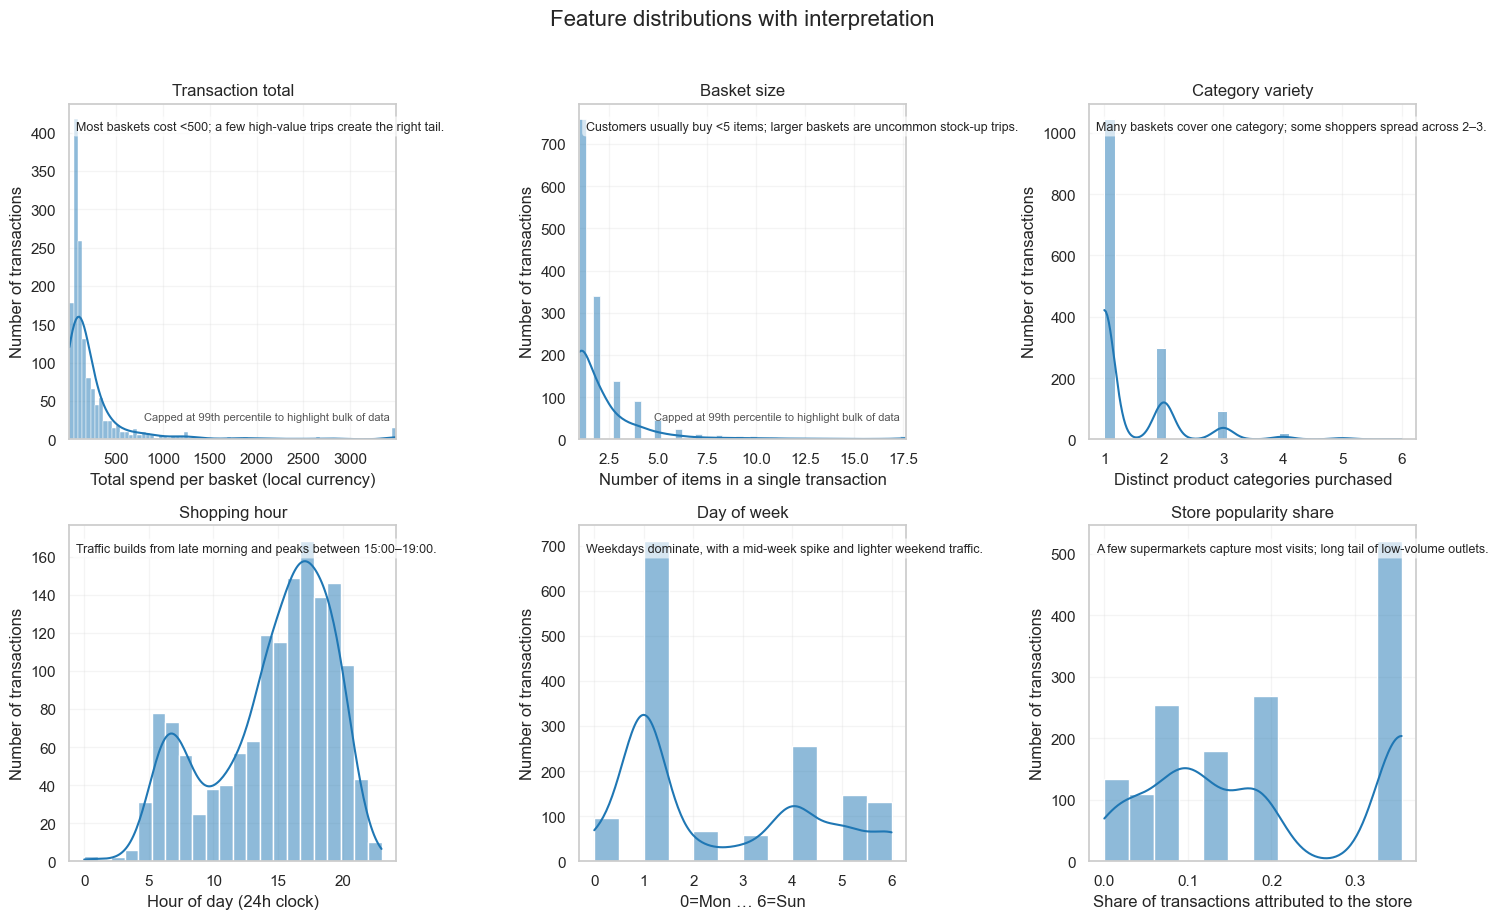

In [100]:
# 4b) Quick feature distributions with contextual notes
feature_cfg = {
    'total': {
        'title': 'Transaction total',
        'xlabel': 'Total spend per basket (local currency)',
        'note': 'Most baskets cost <500; a few high-value trips create the right tail.',
        'clip_quantile': 0.99
    },
    'no_of_items': {
        'title': 'Basket size',
        'xlabel': 'Number of items in a single transaction',
        'note': 'Customers usually buy <5 items; larger baskets are uncommon stock-up trips.',
        'clip_quantile': 0.995
    },
    'variation': {
        'title': 'Category variety',
        'xlabel': 'Distinct product categories purchased',
        'note': 'Many baskets cover one category; some shoppers spread across 2–3.'
    },
    'hour': {
        'title': 'Shopping hour',
        'xlabel': 'Hour of day (24h clock)',
        'note': 'Traffic builds from late morning and peaks between 15:00–19:00.'
    },
    'dayofweek': {
        'title': 'Day of week',
        'xlabel': '0=Mon … 6=Sun',
        'note': 'Weekdays dominate, with a mid-week spike and lighter weekend traffic.'
    },
    'supermarket_freq': {
        'title': 'Store popularity share',
        'xlabel': 'Share of transactions attributed to the store',
        'note': 'A few supermarkets capture most visits; long tail of low-volume outlets.'
    }
}

fig_dist, axs = plt.subplots(2, 3, figsize=(15, 9))
axs = axs.flatten()
for ax, (col, cfg) in zip(axs, feature_cfg.items()):
    if col not in features.columns:
        ax.set_visible(False)
        continue

    series = features[col].dropna()
    clip_q = cfg.get('clip_quantile')
    if clip_q:
        upper = series.quantile(clip_q)
        series = series.clip(upper=upper)
        ax.set_xlim(series.min(), upper)
        ax.text(
            0.98,
            0.05,
            f'Capped at {int(clip_q*100)}th percentile to highlight bulk of data',
            transform=ax.transAxes,
            fontsize=8,
            va='bottom',
            ha='right',
            color='#555555'
        )

    sns.histplot(x=series, ax=ax, kde=True, color='#1f77b4')
    ax.set_title(cfg['title'])
    ax.set_xlabel(cfg['xlabel'])
    ax.set_ylabel('Number of transactions')
    ax.grid(alpha=0.2)
    ax.text(
        0.02,
        0.95,
        cfg['note'],
        transform=ax.transAxes,
        fontsize=9,
        va='top',
        ha='left',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.65, edgecolor='none')
    )

fig_dist.suptitle('Feature distributions with interpretation', fontsize=16, y=1.02)
plt.tight_layout()


Top stores by transaction count:


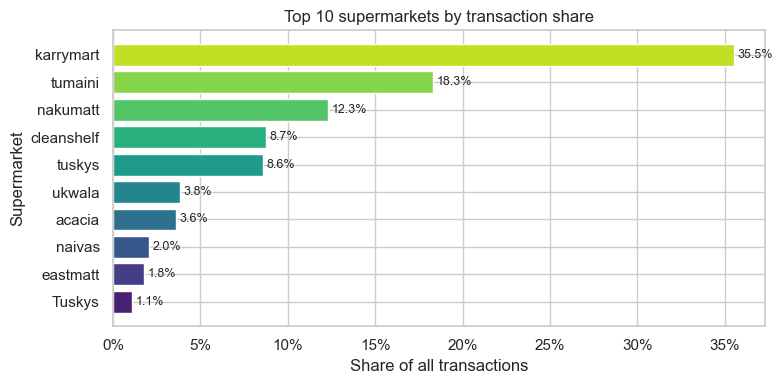

In [101]:
# 4c) Store popularity (top 10 supermarkets by transaction share)
from matplotlib.ticker import FuncFormatter

store_counts = raw_df['supermarket'].fillna('UNKNOWN').value_counts()
store_summary = (
    pd.DataFrame({
        'supermarket': store_counts.index,
        'transactions': store_counts.values
    })
)
store_summary['share'] = store_summary['transactions'] / store_summary['transactions'].sum()

print('Top stores by transaction count:')
store_summary.head(10)

fig_store_pop, ax_store_pop = plt.subplots(figsize=(8, 4))
subset = store_summary.head(10)
ax_store_pop.barh(subset['supermarket'][::-1], subset['share'][::-1], color=sns.color_palette('viridis', len(subset)))
ax_store_pop.set_title('Top 10 supermarkets by transaction share')
ax_store_pop.set_xlabel('Share of all transactions')
ax_store_pop.set_ylabel('Supermarket')
ax_store_pop.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{val:.0%}"))
for idx, (y, share) in enumerate(zip(subset['supermarket'][::-1], subset['share'][::-1])):
    ax_store_pop.text(share + 0.002, idx, f"{share:.1%}", va='center', ha='left', fontsize=9)
plt.tight_layout()


k=2: silhouette=0.5988, inertia=15213.14
k=3: silhouette=0.2452, inertia=12680.09
k=3: silhouette=0.2452, inertia=12680.09
k=4: silhouette=0.2640, inertia=10950.24
k=4: silhouette=0.2640, inertia=10950.24
k=5: silhouette=0.2912, inertia=9292.62
k=5: silhouette=0.2912, inertia=9292.62
k=6: silhouette=0.2957, inertia=7966.07
k=6: silhouette=0.2957, inertia=7966.07
k=7: silhouette=0.2993, inertia=7094.07
k=7: silhouette=0.2993, inertia=7094.07
k=8: silhouette=0.3206, inertia=6372.29
k=8: silhouette=0.3206, inertia=6372.29


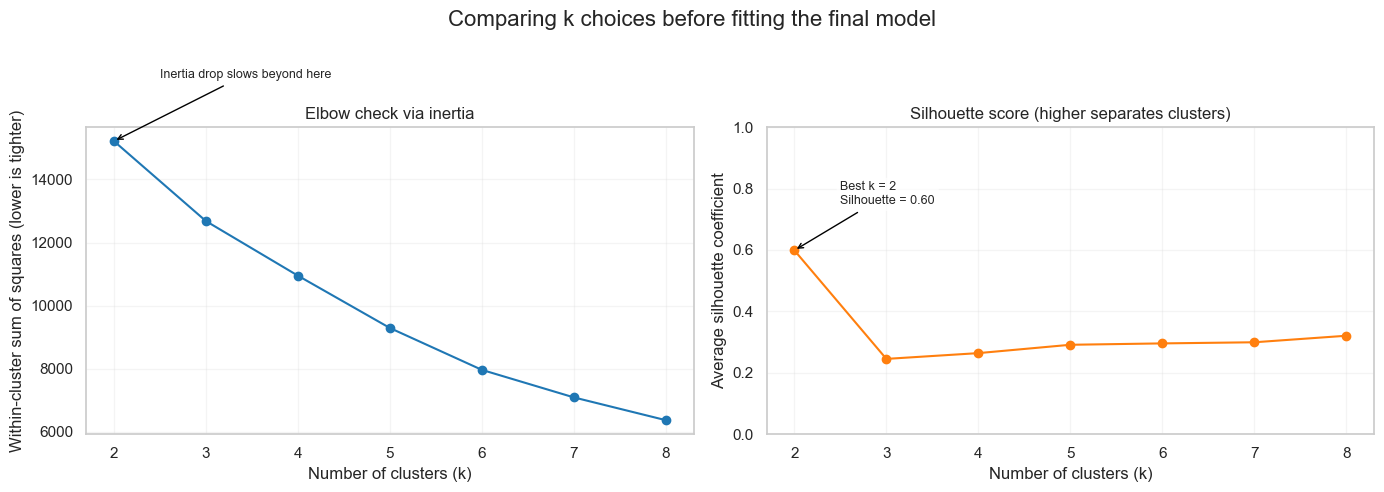

In [102]:
# 5) Scale features and evaluate candidate cluster counts
scaler = StandardScaler()
X = scaler.fit_transform(features)

ks = range(2, 9)
scores = {}
inertias = {}
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    try:
        s = silhouette_score(X, labels)
    except Exception:
        s = float('nan')
    scores[k] = s
    inertias[k] = km.inertia_
    print(f'k={k}: silhouette={s:.4f}, inertia={km.inertia_:.2f}')

best_k = max(scores, key=lambda kk: scores[kk] if not pd.isna(scores[kk]) else -1)

fig_eval, axes = plt.subplots(1, 2, figsize=(14, 5))

# Inertia (Elbow) plot
axes[0].plot(list(inertias.keys()), list(inertias.values()), marker='o', color='#1f77b4')
axes[0].set_title('Elbow check via inertia')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Within-cluster sum of squares (lower is tighter)')
axes[0].grid(alpha=0.2)
axes[0].annotate(
    'Inertia drop slows beyond here',
    xy=(best_k, inertias[best_k]),
    xytext=(best_k + 0.5, inertias[best_k] + 2000),
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
)

# Silhouette plot
axes[1].plot(list(scores.keys()), [scores[k] for k in scores], marker='o', color='#ff7f0e')
axes[1].set_title('Silhouette score (higher separates clusters)')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Average silhouette coefficient')
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.2)
axes[1].annotate(
    f'Best k = {best_k}\nSilhouette = {scores[best_k]:.2f}',
    xy=(best_k, scores[best_k]),
    xytext=(best_k + 0.5, min(scores[best_k] + 0.15, 0.95)),
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=9,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
)

fig_eval.suptitle('Comparing k choices before fitting the final model', fontsize=16)
plt.tight_layout()


In [103]:
# 6) Fit final model with best k and inspect clusters
best_k = max(scores, key=lambda kk: scores[kk] if not pd.isna(scores[kk]) else -1)
print('Best k by silhouette:', best_k, 'score=', scores[best_k])

km_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = km_final.fit_predict(X)
raw_df['cluster'] = labels
features['cluster'] = labels

cluster_sizes = raw_df['cluster'].value_counts().sort_index()
print('\nCluster sizes:\n', cluster_sizes)

cluster_profiles = features.groupby('cluster').mean()
cluster_profiles


Best k by silhouette: 2 score= 0.5987584373803047

Cluster sizes:
 cluster
0    1379
1      85
Name: count, dtype: int64

Cluster sizes:
 cluster
0    1379
1      85
Name: count, dtype: int64


,no_of_items,variation,total,paid,change,hour,dayofweek,is_weekend,month,supermarket_freq,is_cash,is_card,is_mpesa
cluster,,,,,,,,,,,,,
0,2.037708,1.337926,198.569181,364.714286,173.142589,14.405366,2.408267,0.182741,6.168963,0.198474,0.996374,0.000000,0.000000
1,6.705882,2.376471,2148.478941,2165.223529,16.317647,16.341176,2.764706,0.294118,6.964706,0.116538,0.047059,0.341176,0.611765


Generated additional cluster charts


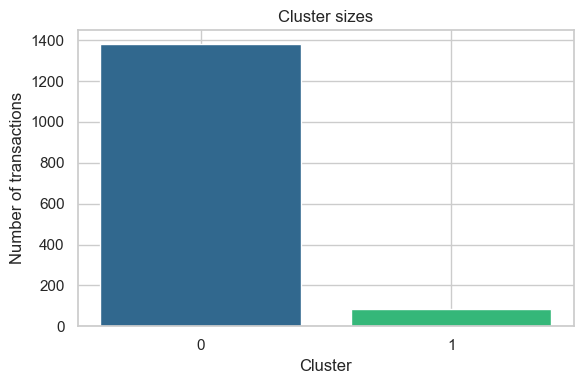

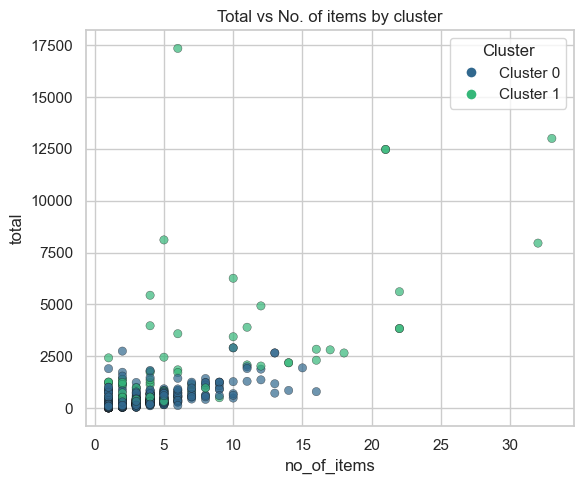

In [104]:
# 6b) Visual summaries
# Ensure output folder exists for any figures
from matplotlib.lines import Line2D
out = Path('..') / 'analysis_output'
out.mkdir(parents=True, exist_ok=True)

# Cluster size bar chart (use matplotlib directly to stay backend-agnostic)
fig_cluster, ax_cluster = plt.subplots(figsize=(6, 4))
ax_cluster.bar(cluster_sizes.index.astype(str), cluster_sizes.values, color=sns.color_palette('viridis', len(cluster_sizes)))
ax_cluster.set_title('Cluster sizes')
ax_cluster.set_xlabel('Cluster')
ax_cluster.set_ylabel('Number of transactions')
plt.tight_layout()

# Scatter of total vs no_of_items coloured by cluster without relying on pandas plotting
fig_scatter = None
if {'total', 'no_of_items', 'cluster'}.issubset(features.columns):
    palette = sns.color_palette('viridis', len(cluster_sizes))
    colour_lookup = {cluster: palette[idx] for idx, cluster in enumerate(cluster_sizes.index)}
    colours = features['cluster'].map(colour_lookup)

    fig_scatter, ax_scatter = plt.subplots(figsize=(6, 5))
    ax_scatter.scatter(features['no_of_items'], features['total'], c=colours, alpha=0.7, edgecolor='k', linewidth=0.3)
    ax_scatter.set_title('Total vs No. of items by cluster')
    ax_scatter.set_xlabel('no_of_items')
    ax_scatter.set_ylabel('total')
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colour_lookup[c], markersize=8, label=f'Cluster {c}') for c in cluster_sizes.index]
    ax_scatter.legend(handles=handles, title='Cluster')
    plt.tight_layout()

print('Generated additional cluster charts')


In [105]:
# 7) Save outputs
out = Path('..') / 'analysis_output'
out.mkdir(parents=True, exist_ok=True)

# save labeled transactions and cluster summaries
raw_df.to_csv(out / 'transactions_with_cluster_from_notebook.csv', index=False)
cluster_profiles.to_csv(out / 'cluster_profiles_mean_from_notebook.csv')
cluster_sizes.to_csv(out / 'cluster_sizes_from_notebook.csv')

# save model and scaler
joblib.dump(km_final, out / 'kmeans_model_from_notebook.joblib')
joblib.dump(scaler, out / 'scaler_from_notebook.joblib')

# persist figures if they exist
# matplotlib.pyplot.Figure.savefig expects a str or file-like; convert Path -> str to satisfy type-checkers
if 'fig_dist' in globals():
    fig_dist.savefig(str(out / 'feature_distributions.png'), dpi=150, bbox_inches='tight')
if 'fig_eval' in globals():
    fig_eval.savefig(str(out / 'k_selection_diagnostics.png'), dpi=150, bbox_inches='tight')
if 'fig_cluster' in globals():
    fig_cluster.savefig(str(out / 'cluster_sizes_bar.png'), dpi=150, bbox_inches='tight')
if 'fig_scatter' in globals() and fig_scatter is not None:
    fig_scatter.savefig(str(out / 'cluster_scatter_total_items.png'), dpi=150, bbox_inches='tight')
if 'fig_store_pop' in globals():
    fig_store_pop.savefig(str(out / 'store_popularity_top10.png'), dpi=150, bbox_inches='tight')

print('Saved outputs to', out)

Saved outputs to ..\analysis_output


In [106]:
# 8) Small cluster inspection and export
out = Path('..') / 'analysis_output'
out.mkdir(parents=True, exist_ok=True)

small_cluster_id = cluster_sizes.idxmin()
small_rows = raw_df[raw_df['cluster'] == small_cluster_id]
print(f'Smallest cluster is {small_cluster_id} with {len(small_rows)} rows')

display(small_rows.head())
summary = small_rows.describe(include='all')
if hasattr(summary.index, 'infer_objects'):
    summary.index = summary.index.infer_objects()
display(summary)

small_rows.to_csv(out / 'cluster_small_rows.csv', index=False)
print('Saved smallest cluster rows to', out)

Smallest cluster is 1 with 85 rows


,supermarket,no_of_items,variation,total,paid,change,type,food,snack,beverage,...,day_1,month,year,hour,item_no_cat,total_cat,paid_cat,change_cat,datetime,cluster
5,nakumatt,22,3,5611.0,5611,0.0,card,yes,no,no,...,24,12,2016.0,16,B,0,2,1,2016-12-24 16:26:00,1
7,chandarana,32,3,7955.0,7955,0.0,mpesa,yes,no,no,...,3,1,2017.0,19,B,0,3,1,2017-01-03 19:03:00,1
10,tuskys,33,6,13005.0,13001,0.0,card,yes,no,no,...,7,12,2016.0,8,B,0,0,1,2016-12-07 08:56:00,1
14,nakumatt,1,1,2420.0,2460,0.0,card,no,no,no,...,11,11,2016.0,8,A,2,4,1,2016-11-11 08:16:00,1
15,nakumatt,12,2,4926.0,4926,0.0,card,yes,no,no,...,11,11,2016.0,8,B,0,0,1,2016-11-11 08:44:00,1


C:\Users\jeff\AppData\Local\Temp\ipykernel_16020\2477773834.py:10: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  summary = small_rows.describe(include='all')


,supermarket,no_of_items,variation,total,paid,change,type,food,snack,beverage,...,day_1,month,year,hour,item_no_cat,total_cat,paid_cat,change_cat,datetime,cluster
count,85,85.000000,85.000000,85.000000,85.000000,85.000000,85,85,85,85,...,85.0,85.000000,85.000000,85.000000,85,85.000000,85.000000,85.0,85,85.0
unique,9,NaN,NaN,NaN,NaN,NaN,4,2,2,2,...,25.0,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,nakumatt,NaN,NaN,NaN,NaN,NaN,mpesa,yes,no,no,...,26.0,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN
freq,37,NaN,NaN,NaN,NaN,NaN,52,56,52,49,...,12.0,NaN,NaN,NaN,60,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.705882,2.376471,2148.478941,2165.223529,16.317647,NaN,NaN,NaN,NaN,...,NaN,6.964706,2016.905882,16.341176,NaN,1.576471,1.882353,1.0,2017-06-12 04:05:12,1.0
min,NaN,1.000000,1.000000,98.000000,98.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,1.000000,2015.000000,5.000000,NaN,0.000000,0.000000,1.0,2015-11-12 17:10:00,1.0
25%,NaN,2.000000,1.000000,424.000000,424.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,6.000000,2017.000000,14.000000,NaN,1.000000,1.000000,1.0,2017-06-02 18:22:00,1.0
50%,NaN,4.000000,2.000000,971.000000,971.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,7.000000,2017.000000,17.000000,NaN,1.000000,1.000000,1.0,2017-07-04 20:18:00,1.0
75%,NaN,8.000000,3.000000,2420.000000,2460.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,8.000000,2017.000000,20.000000,NaN,1.000000,1.000000,1.0,2017-08-22 17:20:00,1.0
max,NaN,33.000000,6.000000,17350.000000,17350.000000,696.000000,NaN,NaN,NaN,NaN,...,NaN,12.000000,2017.000000,23.000000,NaN,6.000000,8.000000,1.0,2017-09-05 21:23:00,1.0


Saved smallest cluster rows to ..\analysis_output
